# Predicting Mercedes Benz Prices in the USA

## Introduction

This project involved a comprehensive analysis of Mercedes-Benz car prices, employing exploratory data analysis (EDA) and feature engineering to uncover key insights.

The goal is to create an accurate price prediction model to support better business decisions, including marketing strategies.

To streamline the process, classes and pipelines were created for automation. Three machine learning models—Elastic Net, Random Forest, and Gradient Boosting—were utilized and compared based on evaluation metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and adjusted R-squared. Ultimately, the Gradient Boosting model was selected for its superior performance in predicting car prices.

## 1. The Data

This dataset contains detailed information on Mercedes-Benz car listings in the USA. It includes a variety of key attributes that provide insights into each vehicle's condition, dealer reputation, and pricing. The dataset features the following columns:
* Name: The make and model of the Mercedes-Benz vehicle.
* Mileage: The car's mileage, measured in miles.
* Rating: The average rating of the car dealership.
* Review Count: The total number of customer reviews for the dealership.
* Price: The selling price of the vehicle in US dollars.

Spanning a diverse selection of Mercedes-Benz models across different years, the dataset allows for an in-depth analysis of how factors like mileage, dealer ratings, and reviews impact the pricing of these vehicles. This analysis will help uncover key insights into pricing trends and factors that influence the value of Mercedes-Benz cars in the used car market.

Data source: https://www.kaggle.com/datasets/danishammar/usa-mercedes-benz-prices-dataset

## 2. Data Exploration and Preprocessing

### 2.1 Import libraries needed for this project

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from joblib import dump,load

### 2.2 Import the CSV Data as Pandas DataFrame

In [8]:
benz = pd.read_csv("data/usa_mercedes_benz_prices.csv")
benz.head()

,Name,Mileage,Rating,Review Count,Price
0,2021 Mercedes-Benz A-Class A 220 4MATIC,"29,636 mi.",3.9,"1,800","$30,900"
1,2022 Mercedes-Benz AMG SL 63 Base,"5,540 mi.",4.7,"1,239","$139,999"
2,2022 Mercedes-Benz AMG SL 63 Base,"4,890 mi.",4.7,"1,239","$132,999"
3,2020 Mercedes-Benz AMG E 53 Base 4MATIC,"29,746 mi.",4.8,752,"$58,587"
4,2021 Mercedes-Benz AMG GLS 63 Base 4MATIC,"32,631 mi.",5.0,"1,502","$95,990"


### 2.3 Data Quality

#### Shape of the dataset

In [9]:
benz.shape

(2429, 5)

#### Check data types

In [10]:
benz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          2429 non-null   object 
 1   Mileage       2429 non-null   object 
 2   Rating        2135 non-null   float64
 3   Review Count  2398 non-null   object 
 4   Price         2429 non-null   object 
dtypes: float64(1), object(4)
memory usage: 95.0+ KB


The dataset consists of 2,429 rows. However, both the Price and Mileage columns contain non-numeric characters that need to be cleaned for analysis. Specifically:

* The Price column includes a dollar sign ($), which must be removed to convert the values into a numeric format.
* The Mileage column contains the text "mi." (indicating miles), which also needs to be stripped to ensure the mileage values are numeric.
* The Review Count column also appear to be non-numeric.

Before proceeding with modeling, these transformations are necessary to prepare the data for analysis and machine learning.

#### Check missing values

In [11]:
benz.isna().sum()

Name              0
Mileage           0
Rating          294
Review Count     31
Price             0
dtype: int64

#### Check Duplicates

In [12]:
benz.duplicated().sum()

np.int64(32)

We observed 32 duplicated records, which introduce redundancy and may lead to biased model training. These repeated samples could cause the model to be overly influenced by specific patterns, ultimately skewing the performance metrics. Removing these duplicates is essential to ensure that the model is trained on diverse, unique data, leading to more reliable and generalizable predictions.

#### Check the number of unique values of "Name" feature.

In [13]:
benz['Name'].value_counts()

Name
2023 Mercedes-Benz CLA 250 Base 4MATIC     70
2023 Mercedes-Benz GLB 250 Base            67
2023 Mercedes-Benz GLB 250 Base 4MATIC     64
2023 Mercedes-Benz C-Class C 300 4MATIC    60
2024 Mercedes-Benz GLE 350 Base 4MATIC     53
                                           ..
2018 Mercedes-Benz C-Class C 300 4MATIC     1
2022 Mercedes-Benz AMG GT 53 C              1
2023 Mercedes-Benz AMG GLB 35               1
2018 Mercedes-Benz CLA 250 Base             1
2023 Mercedes-Benz AMG GT 43 Base           1
Name: count, Length: 486, dtype: int64

The "Name" feature has 486 unique categories, leading to high dimensionality, which can complicate modeling efforts. A notable issue is that some categories only appear once or twice, known as a "thin data" problem. This can result in challenges when predicting for these rare categories, particularly if they are present in the test set but were not seen during training. This lack of representation may cause the model to struggle with accurate predictions for such infrequent levels.

### 2.4 Exploratory Data Analysis (EDA)

#### Custom function to clean the data based on the observation from Data Quality section

In [14]:
def data_prep(df, 
              group_col, 
              agg_col,
              n_level = 2,
              low_threshold = 50000, 
              medium_threshold = 100000, 
              drop_na_col = True,
              drop_duplicates_col = True,
              log_transform = True,
              mileage_outliers = True):
    
  
    '''
    
    This function simplifies data preparation by:
    1. Extracting year from Name and updating the Name column.
    2. Converting specified columns to numeric, cleaning non-numeric characters.
    3. Droping any na's in the Target, duplcates rows, transforming the Target to Log, and removes potential outliers
    4. Grouping and categorizing rows based on aggregation statistics of the agg_col.
    It returns a clean data with the mapping_dict to group some levels if needed as the DataPrepResult class.
    
    '''

    #Step1:
    df['Year'] = df[group_col].str[:4]
    df[group_col] = df[group_col].str[5:]
        
    #Step2:
    col_name_convert = ['Mileage', 'Review Count', 'Price', 'Year']
        
    for col in col_name_convert:
        df[col] = pd.to_numeric(df[col].str.replace(r'\D', '', regex = True), errors = 'coerce')
        

    #Step3:
        
    # Drop rows with missing values in the agg_col column, drop_na_col = True
    if drop_na_col:
        df = df.dropna(subset = agg_col)
        
        
    if drop_duplicates_col:
        df = df.drop_duplicates()
            
    # Apply log transformation to the target variable
    if log_transform:
        df['Log_Price'] = np.log(df[agg_col])
            
    # Removing the potential outliers by setting Mileage less than 125,000
    if mileage_outliers:
        df = df[df['Mileage'] < 125000]
        
        
    #Step4:

    # Group by the specified column and calculate count and average of the aggregation column
    df_group = df.groupby(group_col).agg(
        Name_Count=(group_col, 'count'),
        Avg_Agg_Value=(agg_col, 'mean')
         ).reset_index()

    # Categorize based on thresholds
    df_group.loc[(df_group['Name_Count'] <= n_level) & (df_group['Avg_Agg_Value'] <= low_threshold), 'Adj_Name'] = 'Other_Low'
    df_group.loc[(df_group['Name_Count'] <= n_level) & (df_group['Avg_Agg_Value'] > low_threshold) & 
                    (df_group['Avg_Agg_Value'] <= medium_threshold), 'Adj_Name'] = 'Other_Medium'
    df_group.loc[(df_group['Name_Count'] <= n_level) & (df_group['Avg_Agg_Value'] > medium_threshold), 'Adj_Name'] = 'Other_High'
    df_group.loc[df_group['Name_Count'] > n_level, 'Adj_Name'] = df_group[group_col]

    # Merge the aggregated results back to the original DataFrame
    df = df.merge(df_group, on = group_col)
        
    # Create a mapping dictionary for future use when we will have new unseen data.
    mapping_dict = dict(zip(df['Name'], df['Adj_Name']))
        
    # Dropping the newly created columns that we don't need any more
    df = df.drop(columns = ['Name_Count', 'Avg_Agg_Value', 'Adj_Name'], axis = 1)

    # Return the result as a custom object
    return df, mapping_dict

In [15]:
benz, mapping_dict = data_prep(df = benz,  
                               group_col = 'Name', 
                               agg_col = 'Price')


In [16]:
# View the resulting DataFrame
benz.head()

,Name,Mileage,Rating,Review Count,Price,Year,Log_Price
0,Mercedes-Benz A-Class A 220 4MATIC,29636,3.9,1800.0,30900.0,2021,10.338511
1,Mercedes-Benz AMG SL 63 Base,5540,4.7,1239.0,139999.0,2022,11.849391
2,Mercedes-Benz AMG SL 63 Base,4890,4.7,1239.0,132999.0,2022,11.798097
3,Mercedes-Benz AMG E 53 Base 4MATIC,29746,4.8,752.0,58587.0,2020,10.978268
4,Mercedes-Benz AMG GLS 63 Base 4MATIC,32631,5.0,1502.0,95990.0,2021,11.471999


In [17]:
mapping_dict

{'Mercedes-Benz A-Class A 220 4MATIC': 'Mercedes-Benz A-Class A 220 4MATIC',
 'Mercedes-Benz AMG SL 63 Base': 'Mercedes-Benz AMG SL 63 Base',
 'Mercedes-Benz AMG E 53 Base 4MATIC': 'Mercedes-Benz AMG E 53 Base 4MATIC',
 'Mercedes-Benz AMG GLS 63 Base 4MATIC': 'Mercedes-Benz AMG GLS 63 Base 4MATIC',
 'Mercedes-Benz GLE 350 Base 4MATIC': 'Mercedes-Benz GLE 350 Base 4MATIC',
 'Mercedes-Benz AMG GT C': 'Mercedes-Benz AMG GT C',
 'Mercedes-Benz AMG CLA 45 Base 4MATIC': 'Mercedes-Benz AMG CLA 45 Base 4MATIC',
 'Mercedes-Benz AMG GT 53 Base': 'Mercedes-Benz AMG GT 53 Base',
 'Mercedes-Benz EQB 250 Base': 'Mercedes-Benz EQB 250 Base',
 'Mercedes-Benz CLA 250 Base 4MATIC': 'Mercedes-Benz CLA 250 Base 4MATIC',
 'Mercedes-Benz GLE 450 GLE 450': 'Mercedes-Benz GLE 450 GLE 450',
 'Mercedes-Benz SL 450 SL 450': 'Other_Medium',
 'Mercedes-Benz EQE 350 Base 4MATIC': 'Mercedes-Benz EQE 350 Base 4MATIC',
 'Mercedes-Benz GLC 300 Base 4MATIC': 'Mercedes-Benz GLC 300 Base 4MATIC',
 'Mercedes-Benz AMG GLC 4

#### Check some important statistics

In [18]:
benz.describe()

,Mileage,Rating,Review Count,Price,Year,Log_Price
count,2395.000000,2103.000000,2364.000000,2395.00000,2395.000000,2395.000000
mean,20093.184134,4.534237,1260.292724,55798.16618,2021.766180,10.823828
std,17475.150971,0.385374,1264.744681,31089.92414,1.590892,0.429257
min,100.000000,2.100000,0.000000,15888.00000,2014.000000,9.673319
25%,5879.000000,4.400000,344.000000,38000.00000,2021.000000,10.545341
50%,14150.000000,4.600000,911.000000,46900.00000,2022.000000,10.755773
75%,31259.000000,4.800000,1800.000000,61998.50000,2023.000000,11.034865
max,111752.000000,5.000000,7140.000000,229918.00000,2024.000000,12.345478


The target variable, Price, has one missing value, and with a mean of 55,778 and median of 46,900, which indicates a right-skewed distribution.

This suggests that the distribution has a longer tail on the right side, with higher-priced vehicles pulling the mean above the median.

Additionally, the Rating and Review Count attributes contain some missing values, which need to be addressed before feeding the data into a machine learning algorithm.

Proper handling of these missing values is crucial to ensure the model’s performance and reliability

I will create some columns that I think they will a better predictors than the original ones

''

<Figure size 2000x1200 with 0 Axes>

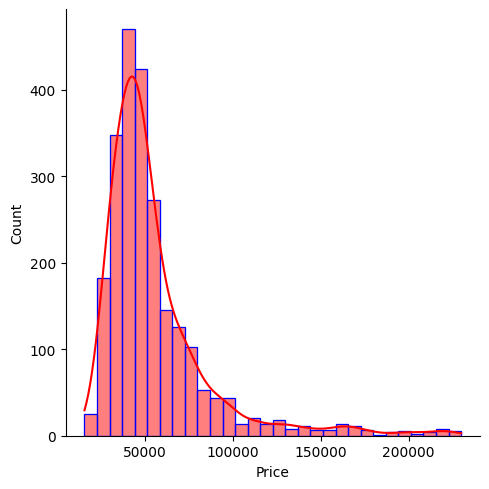

In [19]:
plt.figure(figsize = (10,6),dpi = 200)

sns.displot(x = 'Price',
            data = benz,
            bins = 30,
           color = 'red',
           edgecolor = 'blue',
           lw = 4,
           kde = True)
;

This histogram reveals a right-skewed distribution of prices, with most values clustered around 50,000 USD and a long tail extending to 200,000+ USD, indicating potential outliers. While the distribution is somewhat skewed, it’s not too far from a normal distribution, which is often the case with real-world data where target normality is frequently violated. 

In this case, a log transformation or addressing outliers might still improve model performance.

In [20]:
# Apply log transformation to the target variable
benz['Log_Price'] = np.log(benz['Price'])

''

<Figure size 2000x1200 with 0 Axes>

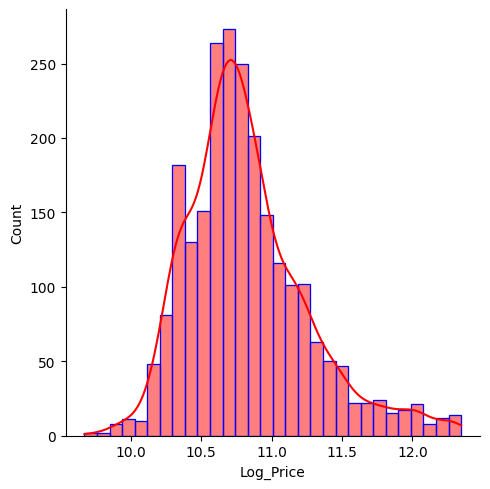

In [21]:
plt.figure(figsize = (10,6),dpi = 200)

sns.displot(x = 'Log_Price',
            data = benz,
            bins = 30,
           color = 'red',
           edgecolor = 'blue',
           lw = 4,
           kde = True)
;

The histogram with a log-transformed target variable (Log_Price) shows a nearly symmetric, bell-shaped distribution, which is a significant improvement compared to a potentially skewed distribution before the log transformation. 

This indicates that the log transformation was effective in normalizing the data, making it more suitable for linear regression or other algorithms that assume normally distributed residuals.

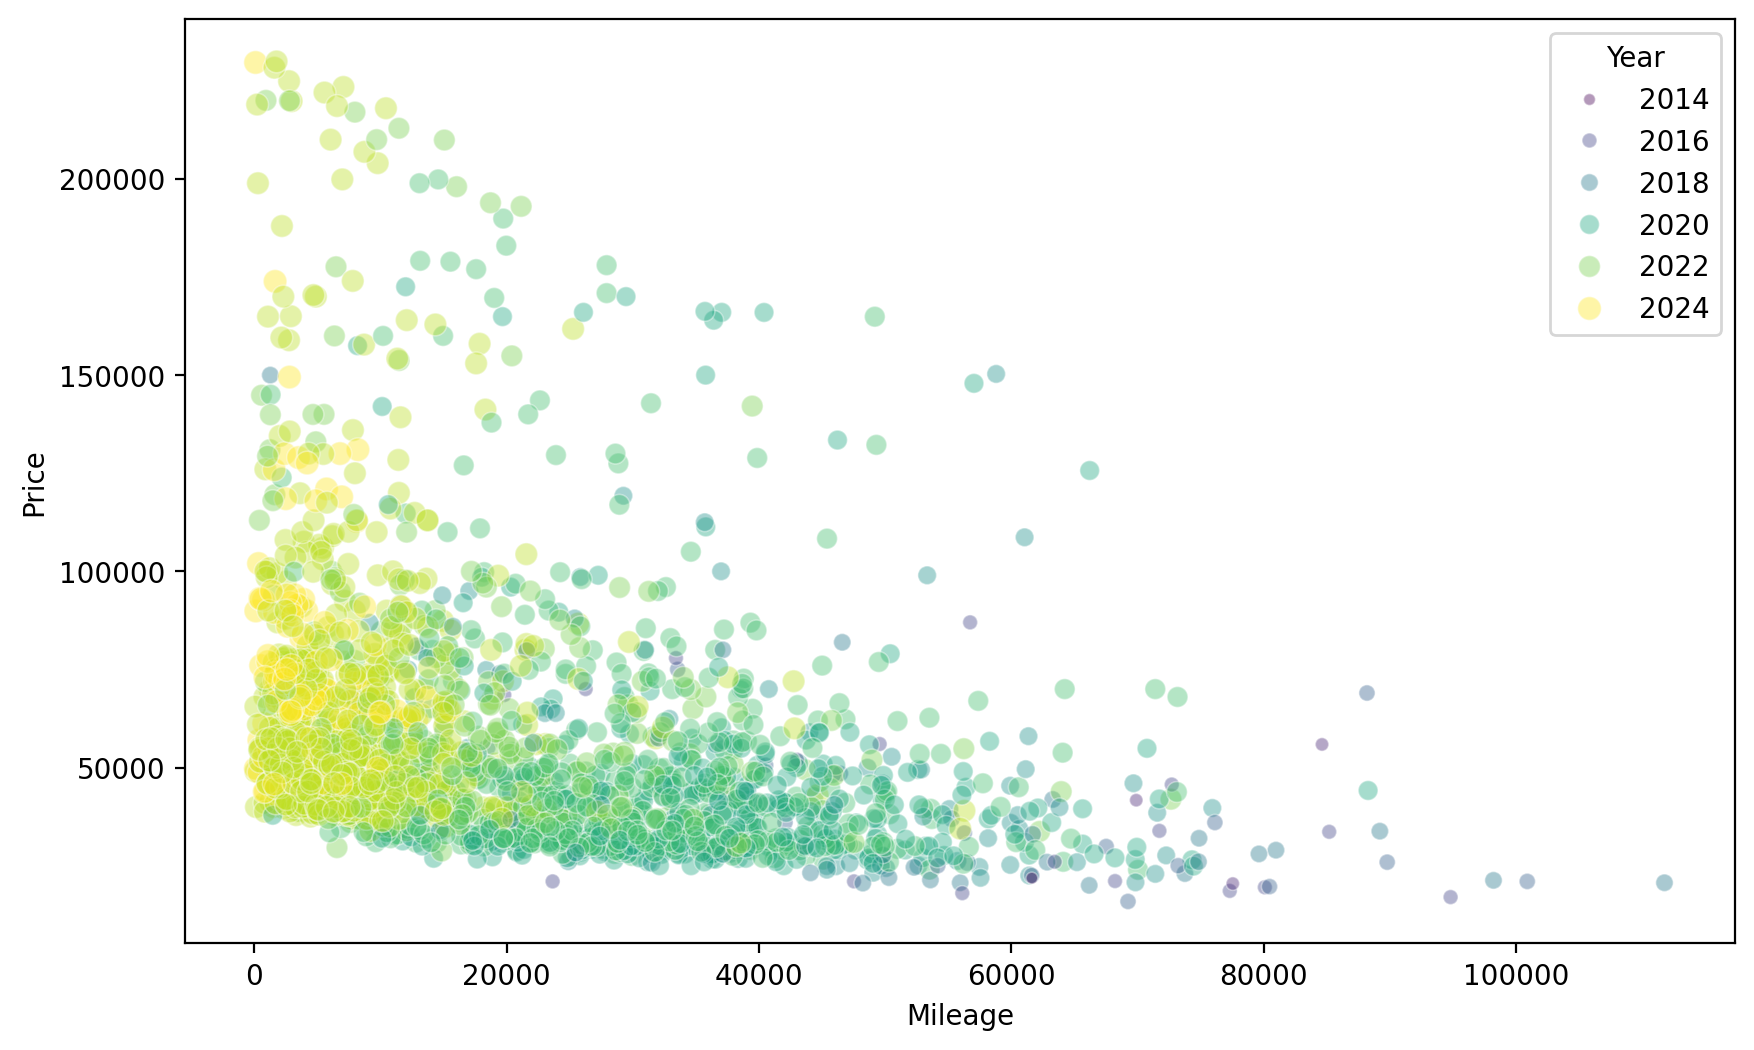

In [22]:
plt.figure(figsize = (10,6), dpi = 200)

sns.scatterplot(data = benz,
                x = 'Mileage',
                y = 'Price',
                hue = 'Year',
                size = 'Year',
               palette = 'viridis',
               alpha = 0.4);

The scatterplot reveals that higher mileage generally corresponds to older cars, indicating a clear negative relationship between these two variables.

Additionally, the data suggests that the Year attribute is positively correlated with the target variable, Price.

This implies that newer models tend to have higher prices, showing that both Mileage and Year are key factors in predicting car prices, with Mileage being inversely related and Year being directly proportional to the Price.

One data point has a mileage close to 200,000, which is significantly higher than the rest of the dataset. Although this point follows the overall trend (where high mileage correlates with lower prices), its extreme value could still distort the analysis. To ensure model accuracy and reduce potential skewing, I will remove this outlier from the data.

In [23]:
# Removing the potential outliers by setting Mileage less than 125,000
benz = benz[benz['Mileage'] < 125000]

In [24]:
benz.shape

(2395, 7)

#### Feature Engineering

In [25]:
benz.loc[benz['Review Count'] == 0, 'Review Count'] = 1
benz.loc[benz['Review Count'].isna(), 'Review Count'] = benz['Review Count'].mean()
benz.loc[benz['Rating'].isna(), 'Rating'] = benz['Rating'].mean()

# Global average rating across all products
C = benz['Rating'].mean()

# Threshold for minimum number of reviews
m = 100  # You can adjust this based on your dataset

# Calculate new columns
benz['Rating_Credibility'] = (benz['Rating'] * benz['Review Count'] + C * m) / (benz['Review Count'] + m) 
benz['Rating_WAvg'] = (benz['Rating'] * benz['Review Count']) / benz['Review Count'].sum()
benz['Mil_Year'] = benz['Mileage'] * benz['Year']

C:\Users\ahmed\AppData\Local\Temp\ipykernel_31832\3626205298.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation = 45)


''

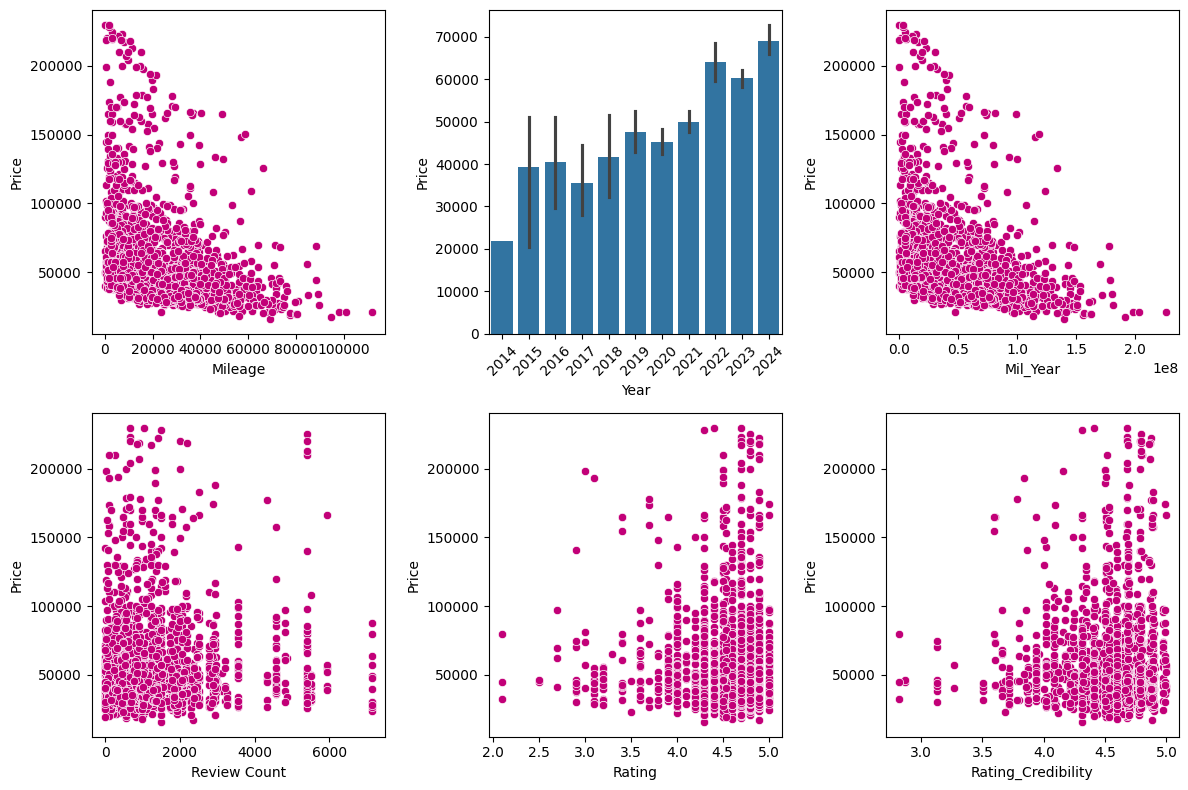

In [26]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))

plt.subplots_adjust(hspace = 1, wspace = 0.5)


sns.scatterplot(data = benz,
                x = 'Mileage',
                y = 'Price',
                color = '#C20078',
                ax = axes[0,0])

sns.barplot(data = benz,
                x = 'Year',
                y = 'Price',
               ax = axes[0,1])

sns.scatterplot(data = benz,
                x = 'Mil_Year',
                y = 'Price',
                color = '#C20078',
               ax = axes[0,2])

sns.scatterplot(data = benz,
                x = 'Review Count',
                y = 'Price',
                color = '#C20078',
               ax = axes[1,0])

sns.scatterplot(data = benz,
                x = 'Rating',
                y = 'Price',
                color = '#C20078',
               ax = axes[1,1])

sns.scatterplot(data = benz,
                x = 'Rating_Credibility',
                y = 'Price',
                color = '#C20078',
               ax = axes[1,2])

axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation = 45)
plt.tight_layout()
;


* The interaction between the Mileage and Year features (combined as Mil_Year) exhibits a relationship with Price similar to that of Mileage alone.

* Year appears to have an upward trend with Price, indicating that newer models tend to be priced higher.

* In contrast, Review Count, Rating, and the engineered feature Rating_Credibility do not demonstrate a linear relationship with Price.

* This suggests that while Mileage and Year significantly influence pricing, the other features do not appear to have a strong linear relationship with Price

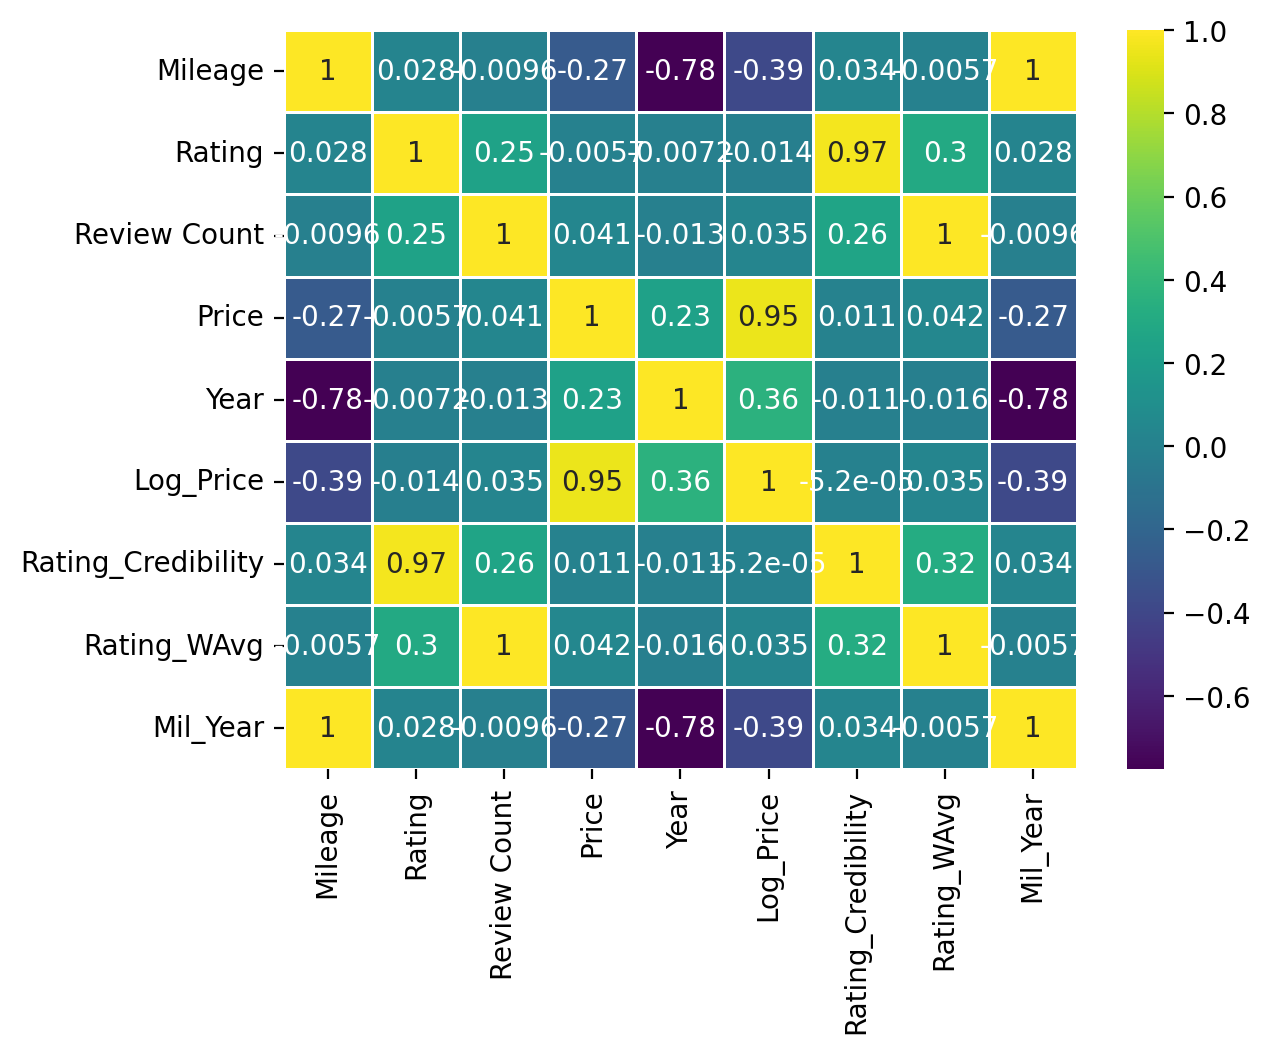

In [27]:
Corr_Matrix = benz.drop(['Name'], axis = 1).corr()

plt.figure(dpi=200)

sns.heatmap(Corr_Matrix,
            lw = 0.5,
           annot = True,
           cmap = 'viridis'
           );

* All the engineered variables exhibit either similar or worse correlation with Price compared to the original features.

* Mileage shows a negative correlation, while Year demonstrates a positive correlation, both with approximately the same magnitude.

* Review Count and Rating reveal very weak correlations with Price.

* The correlation matrix further consolidates these findings, confirming insights gathered from the plots.

* This indicates that while some features may hold potential, they do not significantly enhance predictive power for the target variable
* The predictors are better correlated with Log_Price than with Price

####  Overall, the newly engineered features show weak relationships with the target variable, Price. However, Year and Mileage demonstrate a stronger correlation with Price compared to Rating and Review Count, though they are also highly correlated with each other, which raises concerns about potential multicollinearity among predictors. 
####  The target distribution deviates from normalit, so I will use the Log_Price instead of the price itself. 
####  The data includes some potential outliers, so I dropped one record with very high mileage. 
####  Taking these insights into account, we proceed with training several models and will select the best performer based on their outcomes.